# Dependencias

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

from prophet import Prophet

import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm


from math import sqrt


# Dataset

In [3]:
data = pd.read_csv("./empleo_nacion/empleos_caba.csv")

In [4]:
data.tail()

,fecha,departamento,sector,puestos
9283,2022-12-01,CABA,"Actividades deportivas, recreativas y de entre...",7451
9284,2022-12-01,CABA,Servicios de asociaciones,59850
9285,2022-12-01,CABA,Reparación de computadoras y equipos de uso do...,983
9286,2022-12-01,CABA,Otros servicios personales,4748
9287,2022-12-01,CABA,Otros sectores,1030


In [5]:
# cambiamos el campo fecha de str a datetime
data["fecha"] = data.fecha.apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date())

In [6]:
data_caba = data.groupby(by=["fecha"]).sum().reset_index()

# EDA

## Graficos generales

Inicialmente voy a verificar que no tenga datos nulos en alguna de las clases, para esto extraigo el maximo y minimo del conteo de lineas para cada clase.

In [7]:
cantidad_clases =  len(data.sector.value_counts())
clase_max = data.sector.value_counts().max()
clase_min = data.sector.value_counts().min()

print(f"De un total de {cantidad_clases}, la diferencia entre la clase con mas registros y la clase con menos registros es de {clase_max-clase_min}.\nPor tal motivo podemos afirmar que no tenemos nulos en ninguna clase.")

De un total de 86, la diferencia entre la clase con mas registros y la clase con menos registros es de 0.
Por tal motivo podemos afirmar que no tenemos nulos en ninguna clase.


In [8]:
control = data.loc[data.fecha == pd.to_datetime("2021-01-01")]

In [9]:
control.puestos.mean()

13182.662790697674

In [10]:
data_caba.puestos.min()
data_caba.loc[data_caba.puestos == 1133709]

,fecha,puestos
84,2021-01-01,1133709


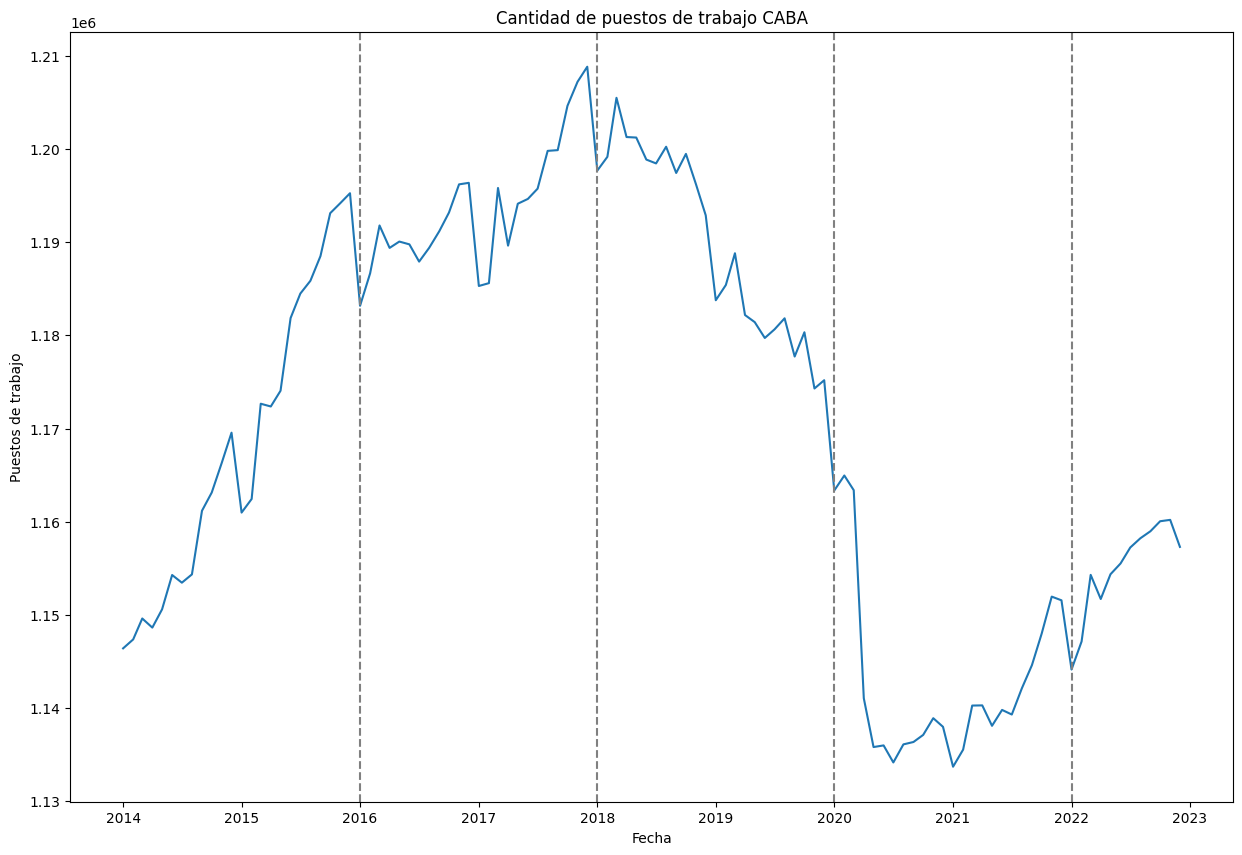

In [11]:
# Graficamos la serie de tiempo
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(data_caba.fecha, data_caba.puestos)
ax.set_title('Cantidad de puestos de trabajo CABA')
ax.set_xlabel('Fecha')
ax.set_ylabel('Puestos de trabajo')

# agregar líneas verticales en el eje x
ax.axvline(x=pd.to_datetime('2016-01-01'), color='gray', linestyle='--')
ax.axvline(x=pd.to_datetime('2018-01-01'), color='gray', linestyle='--')
ax.axvline(x=pd.to_datetime('2020-01-01'), color='gray', linestyle='--')
ax.axvline(x=pd.to_datetime('2022-01-01'), color='gray', linestyle='--')

plt.show()

In [12]:
# creamos una lista de sectores con mayor cantidad de puestos
top_sectore = data.groupby(by=["sector"]).sum().reset_index().sort_values("puestos", ascending = False).head(6).sector.to_list()

#Genero un subset para poder graficarlos
df_top_sectores = data[data.sector.isin(top_sectore)]

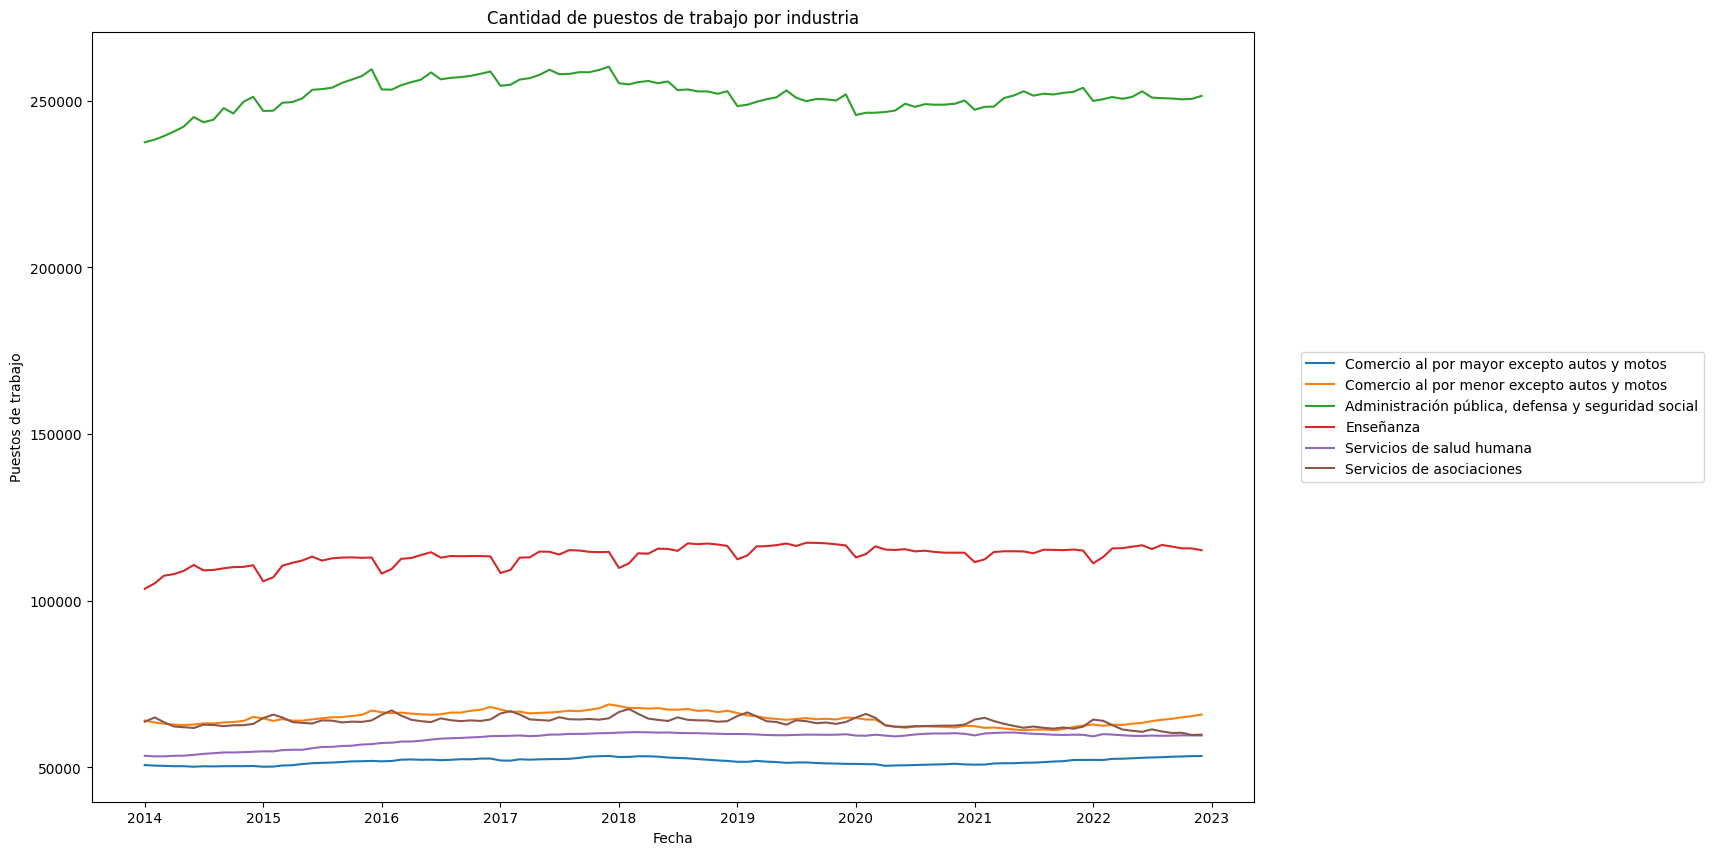

In [13]:
# Visualizar la serie de tiempo por sector
plt.figure(figsize=(15, 10))
sns.lineplot(x='fecha', y='puestos', hue='sector', data=df_top_sectores)
plt.title('Cantidad de puestos de trabajo por industria')
plt.xlabel('Fecha')
plt.ylabel('Puestos de trabajo')
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
plt.show()


In [14]:
# para que el box plot sea mas claro vamos a normalizar a minimo y maximo el dato de cantidad de puestos
puestos_norm = [] #creo una lista vacia donde voy a guardar los valores normalizados

for i in range(0,len(df_top_sectores)): #Itero sobre cada linea del dataframe
    x_clase = df_top_sectores.iloc[i].sector #extraigo clase
    x = df_top_sectores.iloc[i].puestos #extraigo puestos
    x_min = df_top_sectores.loc[df_top_sectores.sector == x_clase, "puestos"].min() #minimo de puestos para la clase dada
    x_max = df_top_sectores.loc[df_top_sectores.sector == x_clase, "puestos"].max() #maximo de puestos para la clase dada

    x_norm = (x-x_min)/(x_max-x_min) #normalizo
    puestos_norm.append(x_norm)

df_top_sectores["puestos_norm"] = puestos_norm #genero una nueva columna y la completo con los datos normalizados

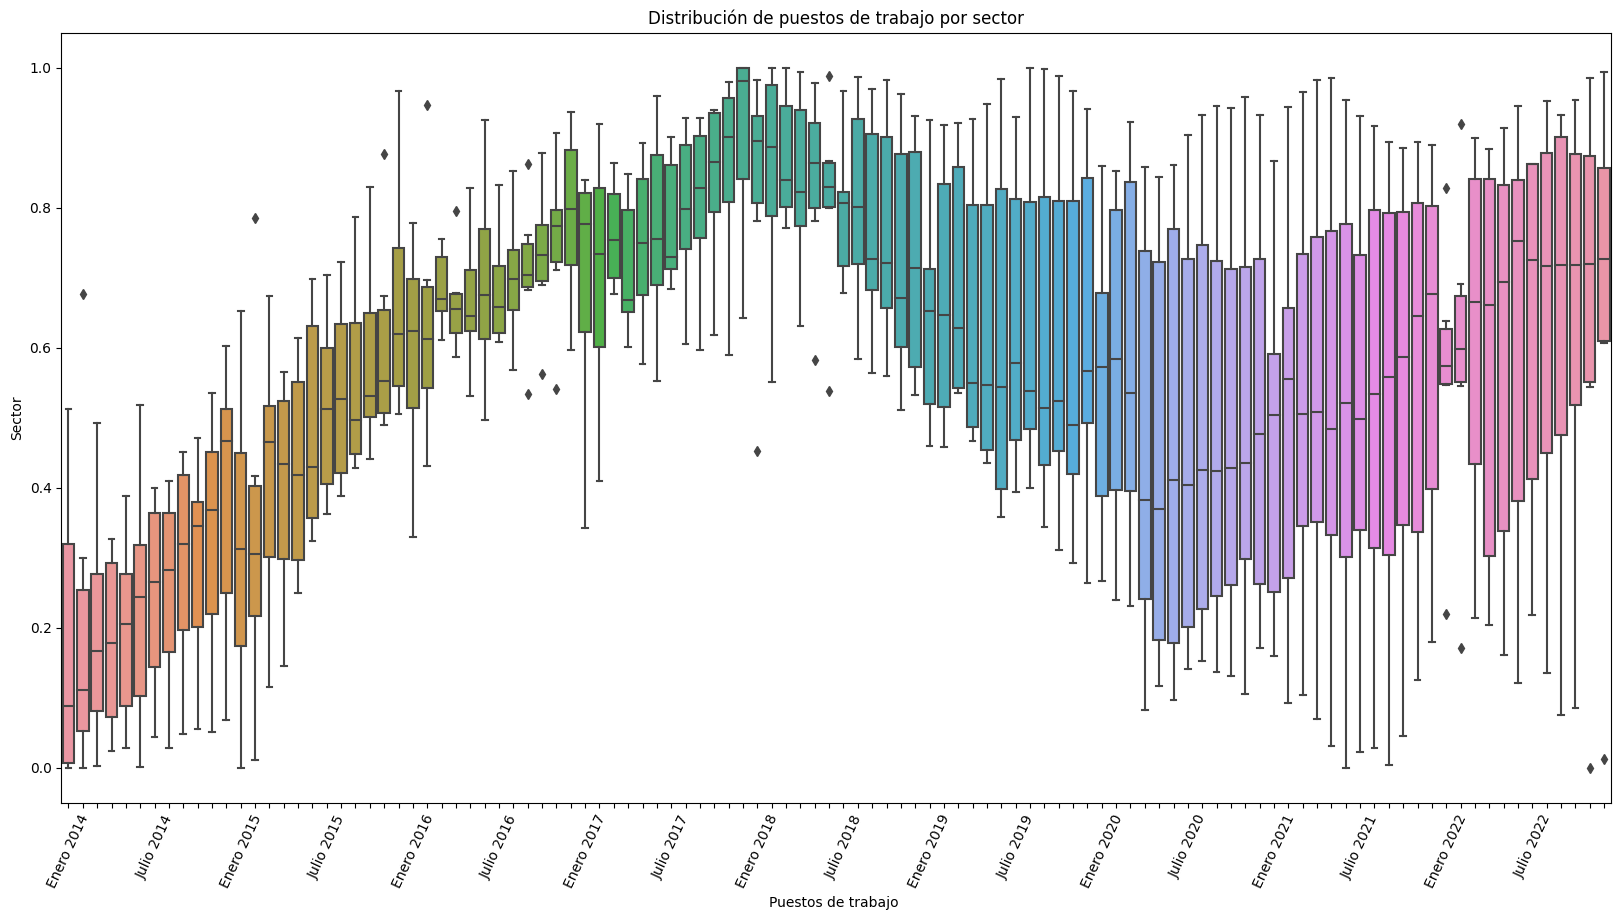

In [15]:
# Visualizo la distribución de puestos de trabajo por sector
plt.figure(figsize=(20, 10))
bx = sns.boxplot(x='fecha', y='puestos_norm', data=df_top_sectores)
bx.set_xticks(range(108))
bx.set_xticklabels(["Enero 2014","","","","","","Julio 2014","","","","","",
                    "Enero 2015","","","","","","Julio 2015","","","","","",
                    "Enero 2016","","","","","","Julio 2016","","","","","",
                    "Enero 2017","","","","","","Julio 2017","","","","","",
                    "Enero 2018","","","","","","Julio 2018","","","","","",
                    "Enero 2019","","","","","","Julio 2019","","","","","",
                    "Enero 2020","","","","","","Julio 2020","","","","","",
                    "Enero 2021","","","","","","Julio 2021","","","","","",
                    "Enero 2022","","","","","","Julio 2022","","","","","",])

plt.title('Distribución de puestos de trabajo por sector')
plt.xlabel('Puestos de trabajo ')
plt.ylabel('Sector')
plt.xticks(rotation = 65) 
plt.show()

In [16]:
df_sector = df_top_sectores.groupby('sector').agg({'puestos': ['mean', 'median', 'min', 'max']})
df_sector.columns = ['Media', 'Mediana', 'Mínimo', 'Máximo']
df_sector

,Media,Mediana,Mínimo,Máximo
sector,,,,
"Administración pública, defensa y seguridad social",251689.555556,251498.0,237558,260209
Comercio al por mayor excepto autos y motos,51805.685185,51841.0,50233,53456
Comercio al por menor excepto autos y motos,64761.879630,64687.5,61181,68936
Enseñanza,113544.064815,114431.0,103616,117412
Servicios de asociaciones,63653.518519,63888.0,59756,67543
Servicios de salud humana,58649.648148,59630.5,53335,60604


## Prophet

Vamos a utilizar prophet para evaluar las tendencias y estacionalidad de la serie temporal. Para ello crearemos tres modelos, el primero eliminando los ultimos tres años de la serie, para evitar los efectos de la pandemia (2020, 2021 y 2022), para el segundo dejaremos el la serie completa y en el ultimo utilizaremos el parametro holiday de prophet para indicar el periodo de 2020 y 2021 como un periodo con anomalias.

### Modelo 1 - Prophet sin 2020, 2021 y 2022

In [17]:
# Genero un nuevo subset para prophet, solo me tengo que quedar con dos columnas "ds" e "y"
# Inicialmente eliminamo la pandemia del modelo
data_prophet = data_caba.loc[data_caba["fecha"] < pd.to_datetime("2020-01-01").date() , ["fecha","puestos"]]
data_prophet.columns = ["ds", "y"]

13:37:25 - cmdstanpy - INFO - Chain [1] start processing
13:37:26 - cmdstanpy - INFO - Chain [1] done processing


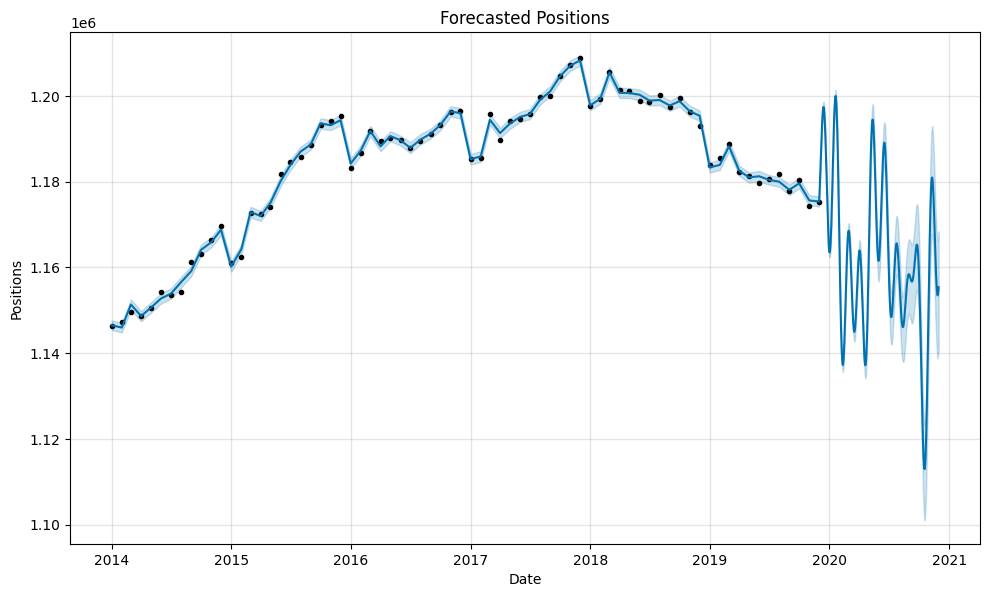

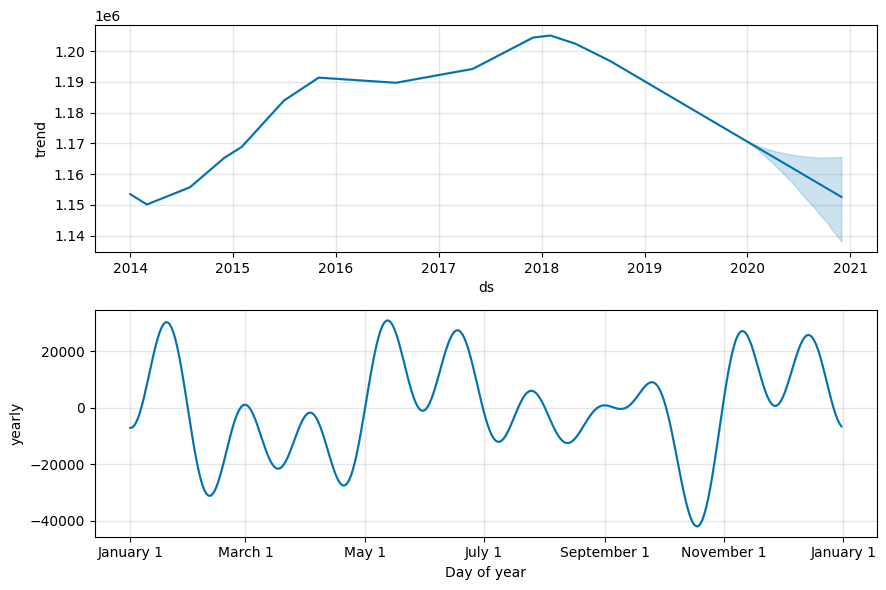

In [18]:
holidays = None  # Por ahora lo dejo en none

# Creo el modelo
modelo1 = Prophet(holidays=holidays)

# Ajusto el modelo a los datos
modelo1.fit(data_prophet)

# Genero el futuro
futuro1 = modelo1.make_future_dataframe(periods=365)  # Por ahora generamos 365 dias

# Hacemos la predicción
forecast1 = modelo1.predict(futuro1)

# Grafico la predicción
fig1 = modelo1.plot(forecast1)
plt.title('Forecasted Positions')
plt.xlabel('Date')
plt.ylabel('Positions')
plt.show()

# Grafico los componentes del modelo, como tenemos datos mensuales vamos a tener estacionalidad mensual y tendencia.
fig2 = modelo1.plot_components(forecast1)
plt.show()

### Modelo 2 - Prophet completo

In [19]:
# Ahora generemos el prophet pero con toda la serie completa
data_prophet = data_caba[["fecha","puestos"]]
data_prophet.columns = ["ds", "y"]

13:37:26 - cmdstanpy - INFO - Chain [1] start processing


13:37:26 - cmdstanpy - INFO - Chain [1] done processing


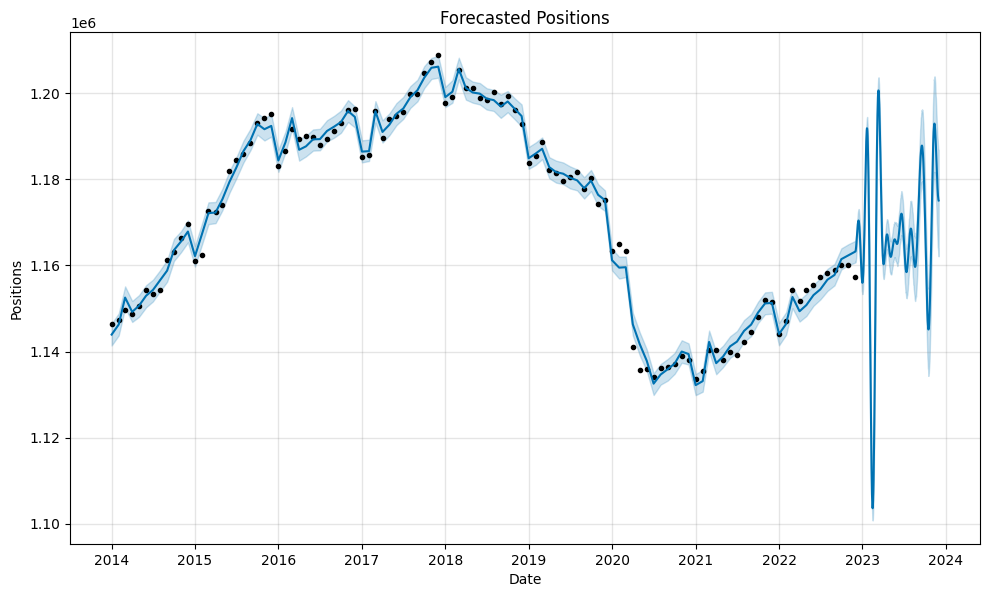

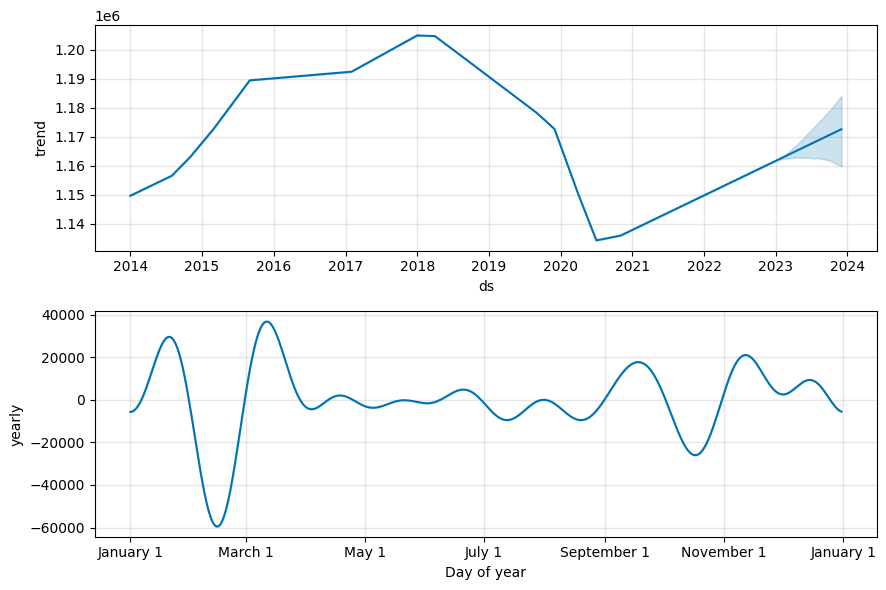

In [20]:
holidays = None  # Por ahora lo dejo en none

# Creo el modelo
modelo2 = Prophet(holidays=holidays)

# Ajusto el modelo a los datos
modelo2.fit(data_prophet)

# Genero el futuro
futuro2 = modelo2.make_future_dataframe(periods=365)  # Por ahora generamos 365 dias

# Hacemos la predicción
forecast2 = modelo2.predict(futuro2)

# Grafico la predicción
fig1 = modelo2.plot(forecast2)
plt.title('Forecasted Positions')
plt.xlabel('Date')
plt.ylabel('Positions')
plt.show()

# Grafico los componentes del modelo, como tenemos datos mensuales vamos a tener estacionalidad mensual y tendencia.
fig2 = modelo2.plot_components(forecast2)
plt.show()

### Modelo 3 - Holiday

In [21]:
# Ahora generemos el prophet pero con toda la serie completa
data_prophet = data_caba[["fecha","puestos"]]
data_prophet.columns = ["ds", "y"]

13:37:27 - cmdstanpy - INFO - Chain [1] start processing


13:37:27 - cmdstanpy - INFO - Chain [1] done processing


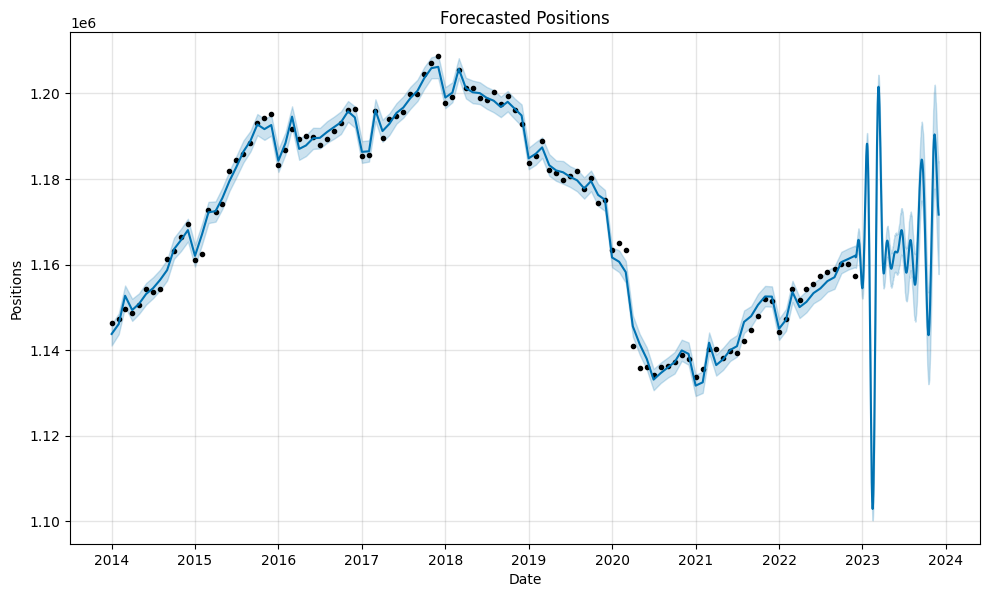

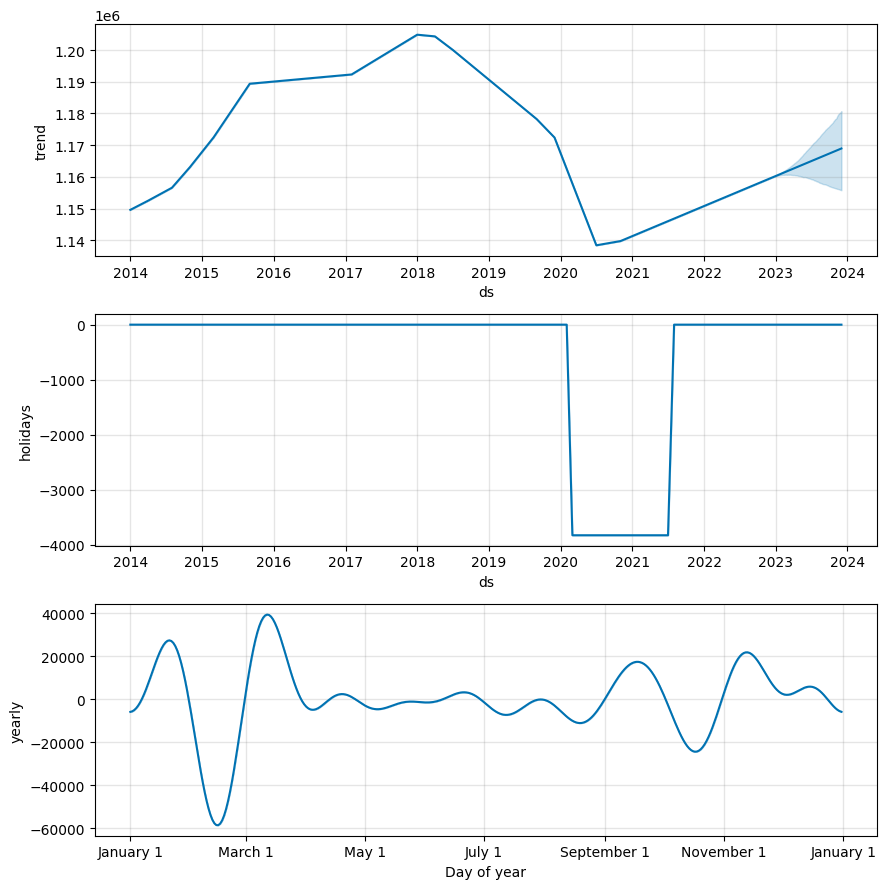

In [22]:
# how to set holiday parameter of a prophet model between 2020-03-01 and 2021-07-31 in python?
holidays = pd.DataFrame({
  'holiday': 'pandemia',
  'ds': pd.to_datetime(['2020-03-01', '2020-04-01', '2020-05-01',
                        '2020-06-01', '2020-07-01', '2020-08-01',
                        '2020-09-01', '2020-10-01', '2020-11-01',
                        '2020-12-01', '2021-01-01', '2021-02-01',
                        '2021-03-01', '2021-04-01', '2021-05-01', 
                        '2021-06-01', '2021-07-01'])  
})

# Creo el modelo
modelo2 = Prophet(holidays=holidays)

# Ajusto el modelo a los datos
modelo2.fit(data_prophet)

# Genero el futuro
futuro2 = modelo2.make_future_dataframe(periods=365)  # Por ahora generamos 365 dias

# Hacemos la predicción
forecast2 = modelo2.predict(futuro2)

# Grafico la predicción
fig1 = modelo2.plot(forecast2)
plt.title('Forecasted Positions')
plt.xlabel('Date')
plt.ylabel('Positions')
plt.show()

# Grafico los componentes del modelo, como tenemos datos mensuales vamos a tener estacionalidad mensual y tendencia.
fig2 = modelo2.plot_components(forecast2)
plt.show()

# Modelo

## ARIMA

In [23]:
# Generar subset con fecha y puestos
df = data_caba[["fecha","puestos"]]

# Genero set de validación 
# Me guardo el 2022 como futuro
test = df.loc[df["fecha"].between(pd.to_datetime("2022-01-01").date() , pd.to_datetime("2022-12-01").date())]

# Genero el set de prueba
df = df.loc[df["fecha"] < pd.to_datetime("2022-01-01").date()]

# Establecer la fecha como índice del DataFrame
df.set_index('fecha', inplace=True)

# Ordenar los datos por fecha
df.sort_index(ascending=True, inplace=True)


# Establecer la fecha como índice del DataFrame
test.set_index('fecha', inplace=True)

# Ordenar los datos por fecha
test.sort_index(ascending=True, inplace=True)

# Verificar si hay valores nulos
if df.isnull().sum().sum() > 0:
    # Manejar los valores nulos según tu estrategia (por ejemplo, rellenar con la media, la mediana, etc.)
    df.fillna(method='ffill', inplace=True)

# Extraer la columna de puestos como serie temporal
ts = df['puestos']

Los parametro de arima son la serie de tiempo y el orden compuesto tres parametros:
<br>

**P: numero de lags,**
<br>

**D: diferencia sobre la serie de tiempo,**

 > - 0 = Utiliza la estacionalidad de la serie de tiempo.
 > - 1 = Elimina tendencias lineales.
 > - 2 = Elimina tendencias cuadraticas.
 <br>

**Q: Tamaño de la media movil utilizada.**

In [24]:
# Ajustar un modelo ARIMA
arima = ARIMA(ts, order=(2, 0, 13))  
# Por lo visto en el prohphet la estacionalidad podria ser de ayuda, ademas no se detectan patrones lineales o cuadraticos en las tendencias.
arima_fit = arima.fit()

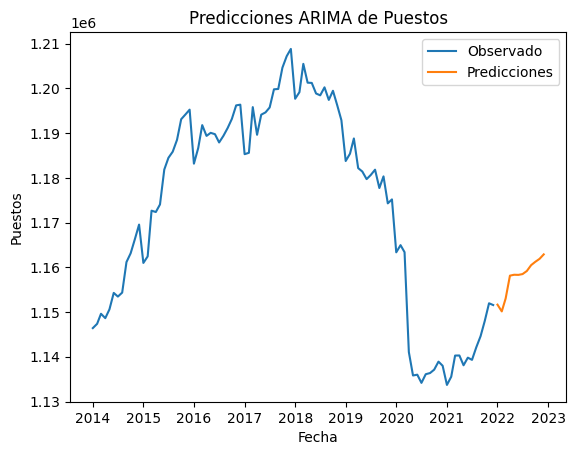

In [25]:

# Realizar predicciones
predictions_arima = arima_fit.predict(start=pd.to_datetime('2022-01-01'), end=pd.to_datetime('2022-12-01')) 


# Visualizar las predicciones
plt.plot(ts, label='Observado')
plt.plot(predictions_arima, label='Predicciones')
plt.xlabel('Fecha')
plt.ylabel('Puestos')
plt.title('Predicciones ARIMA de Puestos')
plt.legend()
plt.show()

In [26]:
# Calculamos el error cuadratico medio
rmse = sqrt(mean_squared_error(test, predictions_arima))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 3791.065


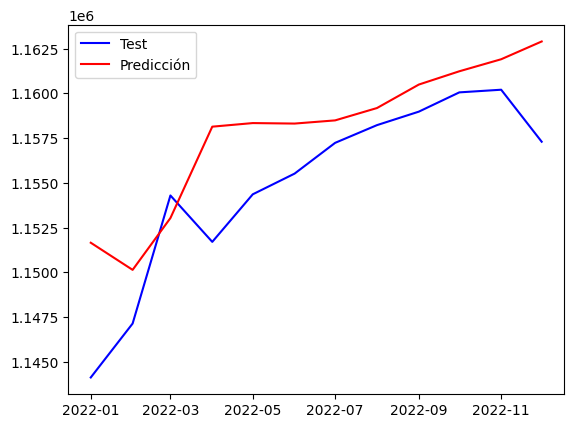

In [27]:
# Generamos un plot de ambas curbas para ver que tan bien estimo el modelo
plt.plot(test, color = "Blue", label = "Test")
plt.plot(predictions_arima, color = "red", label = "Predicción")
plt.legend()
plt.show()

## ARIMAX

In [28]:

dfexo = pd.read_csv("./empleo_nacion/evol_gral_bs_svcios.csv", parse_dates=["fecha"])

In [29]:
# como estoy haciendo muchos cambios genero una copia para no pisar el archivo original
df_exo = dfexo.copy()

# cambiamos el campo fecha de %b-%Y a %Y-%m-%d
df_exo['fecha'] = df_exo['fecha'].apply(lambda x: datetime.strptime(x, "%b-%y").strftime("%Y-%m-%d"))

# cambiamos el campo fecha de str a datetime
df_exo["fecha"] = df_exo.fecha.apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date())

In [30]:
df_exo["general_lag"] = df_exo.general.shift(12)

In [31]:
df_exog_test = df_exo.loc[df_exo["fecha"].between(pd.to_datetime("2022-01-01").date() , pd.to_datetime("2022-12-01").date())]

df_exo = df_exo.loc[df_exo["fecha"].between(pd.to_datetime("2014-01-01").date() , pd.to_datetime("2021-12-01").date())]

df_exo.set_index('fecha', inplace=True)

In [32]:
endog = df['puestos']
exog = df_exo['general_lag']
order = (12, 1, 18)

arimax = sm.tsa.statespace.SARIMAX(endog=endog, exog=exog, order=order)
arimax_fit = arimax.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           32     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.96724D+00    |proj g|=  1.00348D+01


 This problem is unconstrained.



At iterate    5    f=  9.82057D+00    |proj g|=  1.49020D-01

At iterate   10    f=  9.80829D+00    |proj g|=  3.73391D+00

At iterate   15    f=  9.75104D+00    |proj g|=  3.06698D+00

At iterate   20    f=  9.74247D+00    |proj g|=  2.58987D-01

At iterate   25    f=  9.73591D+00    |proj g|=  1.31274D+00

At iterate   30    f=  9.66886D+00    |proj g|=  5.83778D+00

At iterate   35    f=  9.65529D+00    |proj g|=  1.14003D+00

At iterate   40    f=  9.64009D+00    |proj g|=  2.23610D+00

At iterate   45    f=  9.60656D+00    |proj g|=  2.38339D+00

At iterate   50    f=  9.57162D+00    |proj g|=  4.90891D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

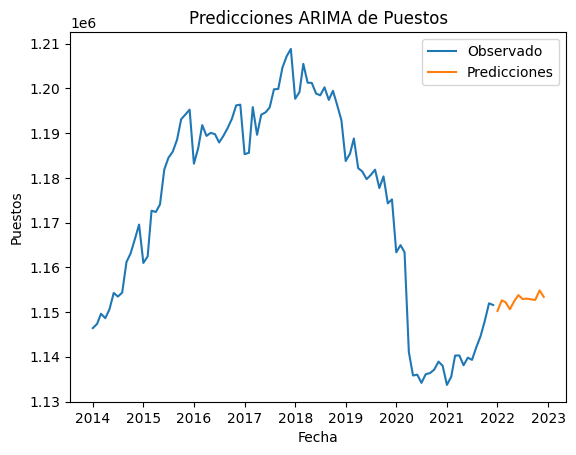

In [33]:
# Realizar predicciones
predictions_arimax = arimax_fit.forecast(steps = 12, exog = df_exog_test.general_lag ) 

# Visualizar las predicciones
plt.plot(ts, label='Observado')
plt.plot(predictions_arimax, label='Predicciones')
plt.xlabel('Fecha')
plt.ylabel('Puestos')
plt.title('Predicciones ARIMA de Puestos')
plt.legend()
plt.show()

In [34]:
# Calculamos el error cuadratico medio
rmse = sqrt(mean_squared_error(test, predictions_arimax))
rmse

4665.460323109922

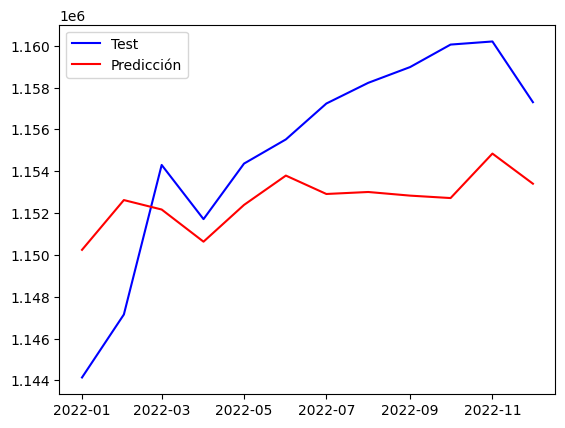

In [35]:

# Generamos un plot de ambas curbas para ver que tan bien estimo el modelo
plt.plot(test, color = "Blue", label = "Test")
plt.plot(predictions_arimax, color = "red", label = "Predicción")
plt.legend()
plt.show()
